In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import imageio

In [ ]:
class SARSA_Agent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):

        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob

    # get action using epsilon greedy policy
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num = random.uniform(0, 1)

        # if random_num > epsilon --> exploitation (greedy)
        if random_num > epsilon:
            # Take the action with the highest value given a state
            action = int(np.argmax(self.q_table[state]))
        # else --> exploration
        else:
            action = int(self.env.action_space.sample())

        return action

    def update_parameters(self, state, action, reward, next_state, epsilon):
        """
        SARSA update:
        Q(s,a) := Q(s,a) + alpha * [ r + gamma * Q(s', a') - Q(s,a) ]
        where a' is the action sampled from the current policy (epsilon-greedy) at s'
        """
        # choose next action according to the current policy (on-policy)
        next_action = self.get_action(next_state, epsilon)

        # old value
        old_value = self.q_table[state, action]
        # Q(s', a')
        next_q = self.q_table[next_state, next_action]
        # SARSA update
        new_value = old_value + self.alpha * (reward + self.gamma * next_q - old_value)

        # update the q_table
        self.q_table[state, action] = new_value

In [ ]:
def train(n_training_episodes, max_steps, env, agent):
    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_training_episodes)):
        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        # Reduce epsilon (because we need less and less exploration)
        epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate * episode)

        # Reset the environment
        state, info = env.reset()
        terminated = False
        truncated = False

        # repeat (safety cap via max_steps)
        while not (terminated or truncated):
            # stop if we exceed max_steps
            if total_steps_ep >= max_steps:
                break

            # Choose the action At using epsilon greedy policy
            action = agent.get_action(state, epsilon)

            # Take action At and observe Rt+1 and St+1
            next_state, reward, terminated, truncated, info = env.step(action)

            total_rewards_ep += reward
            total_steps_ep += 1
            if reward == -10:
                total_penalties_ep += 1

            # Update Q(s,a) using SARSA (on-policy)
            agent.update_parameters(state, action, reward, next_state, epsilon)

            # Our next state is the new state
            state = next_state

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

        # append metrics for this episode (ONE append per episode)
        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    return episode_rewards, episode_steps, episode_penalties

In [ ]:
# Training parameters
n_training_episodes = 30000  # Total training episodes
alpha= 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 200        # Total number of test episodes

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.02            # Minimum exploration probability
decay_rate = 0.0009            # Exponential decay rate for exploration prob

In [ ]:
#env=gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent=SARSA_Agent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, max_steps, env,agent)

100%|██████████| 30000/30000 [00:22<00:00, 1310.66it/s]


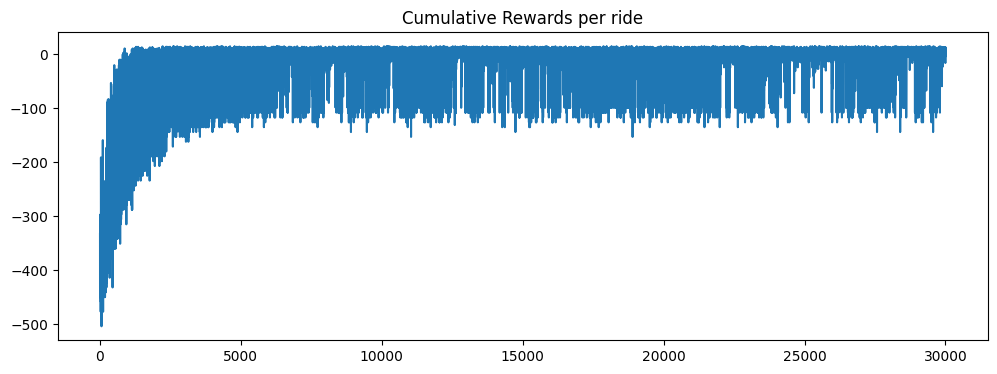

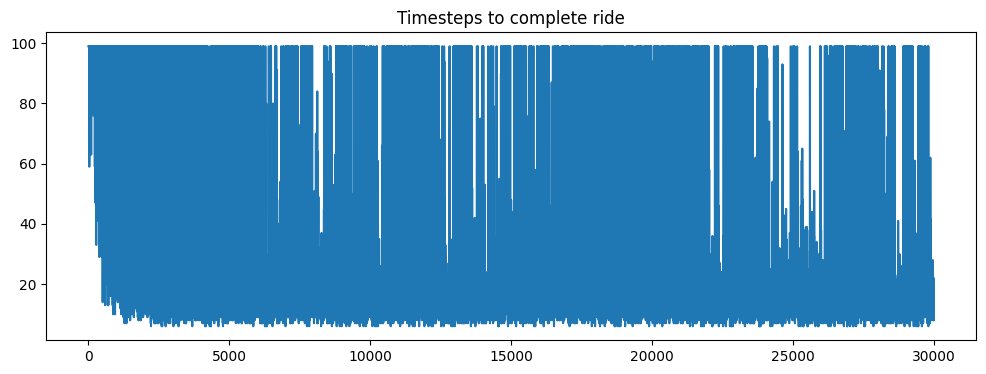

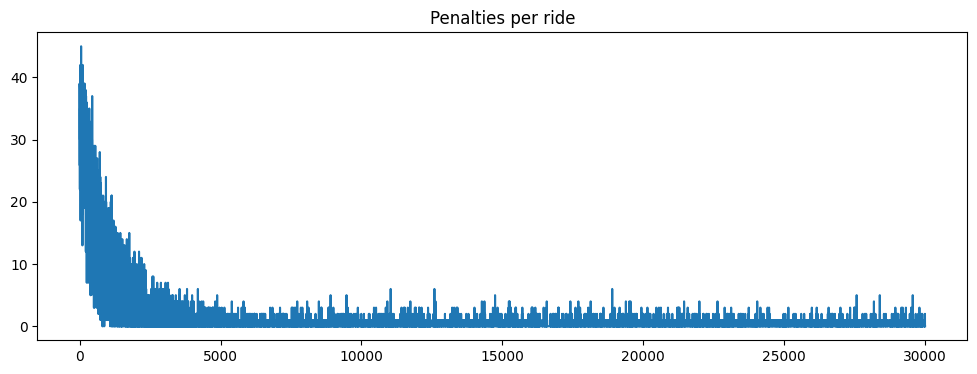

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [ ]:
def evaluate_agent(env, agent, n_eval_episodes=200, max_steps=200):
    rewards = []
    steps = []
    penalties = []
    for ep in range(n_eval_episodes):
        state, info = env.reset()
        terminated = False; truncated = False
        total_reward = 0
        total_steps = 0
        total_penalties = 0
        while not (terminated or truncated) and total_steps < max_steps:
            action = agent.get_action(state, 0.0)  # greedy
            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            total_steps += 1
            if reward == -10:
                total_penalties += 1
            state = next_state
        rewards.append(total_reward)
        steps.append(total_steps)
        penalties.append(total_penalties)
    return np.mean(rewards), np.std(rewards), rewards, steps, penalties

In [ ]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 3500)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=5.35 +/- 19.36


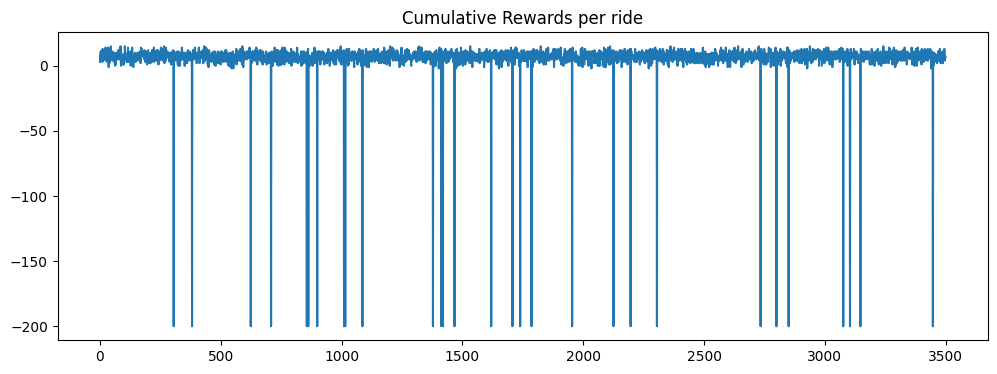

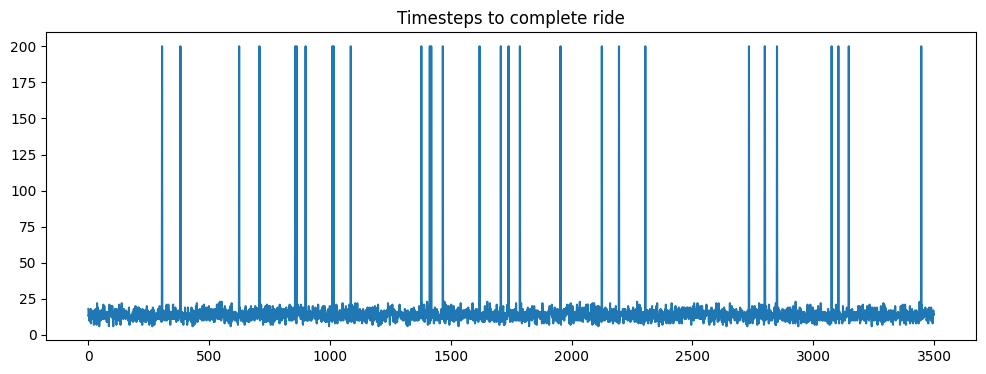

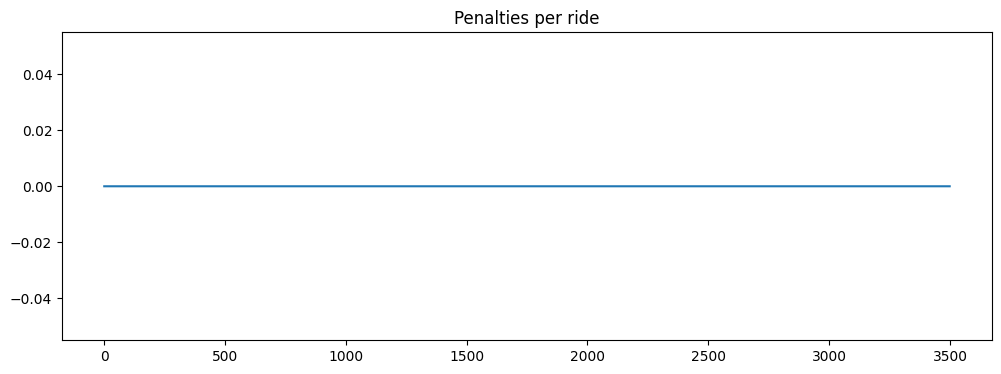

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [ ]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  steps = 0
  while not (terminated or truncated) and steps < 500:
        action = int(np.argmax(agent.q_table[state][:]))
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
        steps += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

# generate the video

In [ ]:

from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./sarsa_replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)